In [7]:
using JLD
using PyPlot
using Statistics, StatsBase
using Clustering
using Distances  # Este es necesario para hacer la matriz de distancia, es complemento a Clustering.

In [8]:
push!(LOAD_PATH, "../Preprocesamiento/")
push!(LOAD_PATH, ".")
using ArraySetTools # pa aprovechar las cosas que ya tenemos.
using Aglomerar

In [9]:
using LsqFit

In [10]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP)

2000

In [11]:
# Datos ordenados 4dimensionalmente.
# vamos a usar masa maxima y tiempo maximo normalizados a 64 (dist max.)
# para hacer un hipercubo platonico y hacer el apiñonamiento jerárquico ahi.

function dictatablaCM(datos::Dict)

    fruncio=Array{Float64}(undef, 0,4)

    for k in keys(datos)
        dat=datos[k]
        (alto, ancho)=size(dat)
        auxt=ones(alto).*k
        afafa=hcat(dat, auxt)
        fruncio=vcat(fruncio,afafa)
    end

    fruncio=fruncio[sortperm(fruncio[:, 4]), :];
    return fruncio

end



dictatablaCM (generic function with 1 method)

In [12]:
tablapos=dictatablaCM(DatosCMP)
tablaneg=dictatablaCM(DatosCMN);

In [13]:
masamax=maximum(tablapos[:,3])

12329.550282478333

In [14]:
nmax=maximum(fruncio[:,4])

UndefVarError: UndefVarError: fruncio not defined

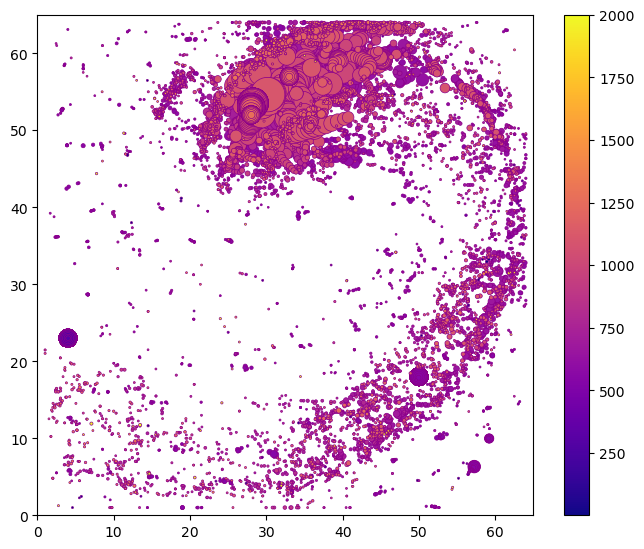

In [15]:
fig=plot4Ddiscs(tablapos)

In [16]:
histogordis=fit(Histogram, tablapos[:,3], 1:20:5001)

Histogram{Int64,1,Tuple{StepRange{Int64,Int64}}}
edges:
  1:20:5001
weights: [0, 386, 2840, 1481, 885, 491, 324, 242, 178, 162  …  1, 3, 3, 1, 3, 3, 1, 1, 3, 0]
closed: left
isdensity: false

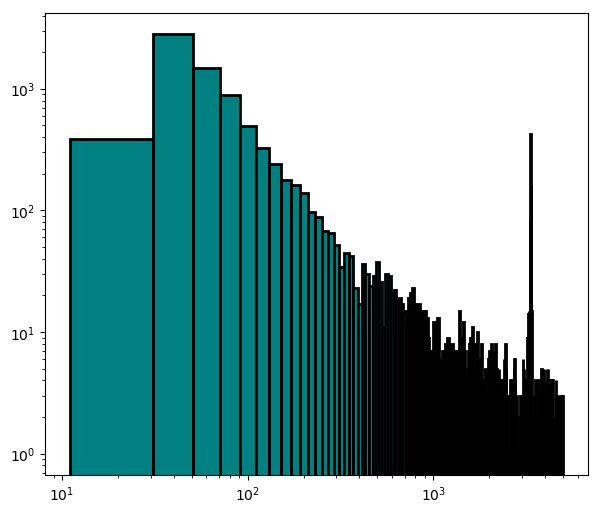

In [17]:
#histogordis.weights
figure(figsize=(7,6))
bar(histogordis.edges[1][1:end-1], histogordis.weights, width=20, 
    color="teal", edgecolor="k", linewidth=2)
yscale("log")
xscale("log")
show()

In [18]:
gmin=nquantile(abs.(tablaneg[:,3]), 10)[2]
tablanegredux=tablaneg[abs.(tablaneg[:,3]).>gmin,:];

In [19]:
gmin=nquantile(tablapos[:,3], 10)[2]
tablaposredux=tablapos[tablapos[:,3].>gmin,:]
size(tablaposredux)

(8856, 4)

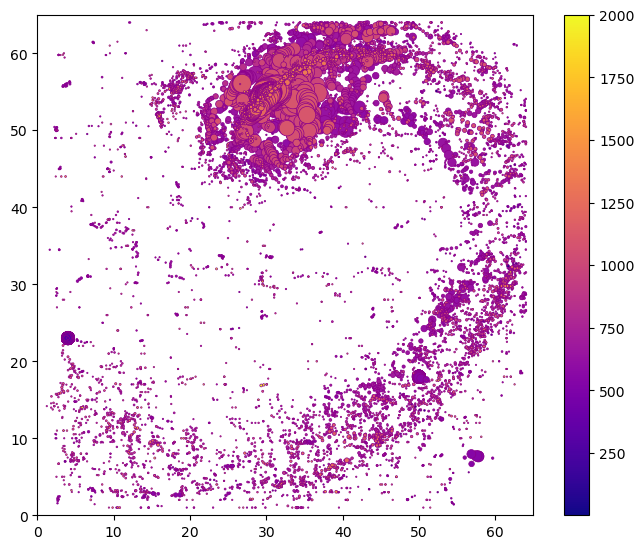

In [20]:
plot4Ddiscs(tablaneg, escala=0.025)


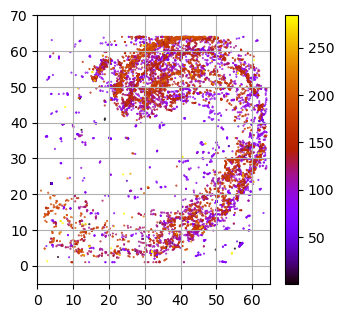

In [21]:
fafa=figure(figsize=(3.75,3.5))

axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
tuabuela=fafa.get_axes()
xticks(collect(0:10:61))

tiempos=round.(tablaposredux[:,4]./7.022, digits=1)

scatter(tablaposredux[:,1], tablaposredux[:,2], c=tiempos, cmap="gnuplot", s=0.2)
grid("on")
colorbar()
savefig("puntoscmfacpostcolor.png", dpi=90)

In [84]:
histtneg=fit(Histogram, tablanegredux[:,4], 1:10:2000)

Histogram{Int64,1,Tuple{StepRange{Int64,Int64}}}
edges:
  1:10:1991
weights: [35, 13, 18, 10, 13, 12, 15, 19, 12, 16  …  2, 7, 4, 1, 7, 3, 5, 10, 12, 1]
closed: left
isdensity: false

In [22]:
figure(figsize=(7,6))
bar(histtneg.edges[1][1:end-1], histtneg.weights, width=10, 
    color="teal", edgecolor="k", linewidth=2)
#yscale("log")
#xscale("log")
show()

UndefVarError: UndefVarError: histtneg not defined

In [23]:
size(tablaposredux)

(8856, 4)

In [32]:
# clust1=fruncio[:,1:2];
preclustpos=permutedims(tablaposredux)
preclustneg=permutedims(tablanegredux)

4×9837 Array{Float64,2}:
  46.4202    16.3458   43.0113   43.4658   …    21.7873    58.1566    33.8971
   6.47653   59.0      19.0       3.38839       17.0       10.1941    63.0   
 -54.9166   -51.6584  -78.7192  -65.7246       -55.0426   -59.2675   -72.0986
   1.0        1.0       1.0       1.0         2000.0     2000.0     2000.0   

In [33]:
preclustpos[3,:]=normalizar1(preclustpos[3,:]).*64
preclustpos[4,:]=normalizar1(preclustpos[4,:]).*64;
preclustneg[3,:]=normalizar1(preclustneg[3,:]).*64
preclustneg[4,:]=normalizar1(preclustneg[4,:]).*64;

In [36]:
preclustpos=vcat(preclustpos[1:2,:], transpose(preclustpos[4,:]))
preclustneg=vcat(preclustneg[1:2,:], transpose(preclustneg[4,:]))

BoundsError: BoundsError: attempt to access 3×9837 Array{Float64,2} at index [4, Base.Slice(Base.OneTo(9837))]

In [66]:
function scatterclust(puntos, clustn)

fafa=figure(figsize=(3.75,3.5))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(puntos[:,1],puntos[:,2], s=0.2, c=clustn, cmap="nipy_spectral")
colorbar(fraction=0.045)
    grid()
end

scatterclust (generic function with 1 method)

In [67]:

dd3dpos=pairwise(Euclidean(), preclustpos, dims=2);
dd3dneg=pairwise(Euclidean(), preclustneg, dims=2);


# Aquí abajo esta DBSCAN


In [68]:
db3dpos=dbscan(dd3dpos, 1.75, 4)
db3dneg=dbscan(dd3dneg, 1.75, 4)


DbscanResult([5, 8, 44, 56, 123, 150, 235, 246, 247, 276  …  9605, 9607, 9613, 9625, 9701, 9732, 9739, 9765, 9799, 9805], [0, 0, 0, 0, 1, 0, 0, 2, 0, 4  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [9, 295, 12, 6, 5, 8, 5, 5, 29, 7  …  5, 5, 5, 4, 10, 4, 4, 4, 4, 4])

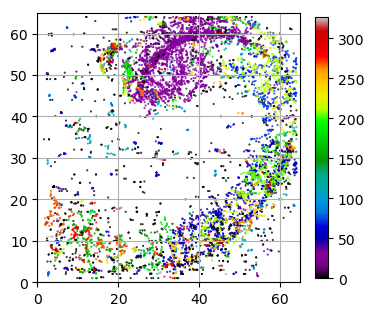

In [70]:
scatterclust(tablanegredux, db3dneg.assignments)
savefig("dbscannegejem01.png",dpi=92)

In [21]:
aver=count(x->x==0, db3d.assignments)

976

In [22]:
aver=count(x->x==0, db3d.assignments)

976

In [23]:
length(0:112)

113

In [98]:
function historango(asignamientos)
    la=length(unique(asignamientos))
    tamgroups=fit(Histogram, asignamientos, 0:la, closed=:left)
    ordenado=sortperm(tamgroups.weights, rev=true)
    return (tamgroups, ordenado)
end

historango (generic function with 1 method)

In [99]:
residuo(unos, otros)=sum((unos.-otros).^2)

function rsquared(reales, modelos)
    sstot=sum((reales.-mean(reales)).^2)
    ssreg=sum((modelos.-mean(reales)).^2)
    ssres=sum((reales.-modelos).^2)
    res=1-ssres/sstot
    otrores=ssreg/sstot
    return ( res, otrores)
end
    

rsquared (generic function with 1 method)

In [100]:
# por alguna razon me da buena espina ajustar en espacio log
@. linmodel(x,p)=p[2]*x+p[1]



function dbscanfit(datosdist; radio=1.0, tantos=4)
    db=dbscan(datosdist, radio, tantos)
    sinasignar=count(x->x==0, db.assignments)
    ngrups=length(unique(db.assignments))
    
    (histo, orden)=historango(db.assignments)
    xdata=histo.edges[1][1:end-1];
    ydata=histo.weights[orden];

    elgrande=ydata[1]
    
    xdatalin=log.(xdata.+1)
    ydatalin=log.(ydata);
    p0=Float64[7, -1.5]
    lwlin=Float64[5, -4]
    uplin=Float64[15, 0]
    
    fitlin=curve_fit(linmodel, xdatalin, ydatalin, p0, lower=lwlin, upper=uplin)
    
    fauxlin(x)=linmodel(x, fitlin.param)
    
    yysmlin=fauxlin.(xdatalin);
    
    (rr1, rr2)=rsquared(ydatalin, yysmlin)
    
    return (rr1, rr2 ,fitlin, sinasignar, elgrande, ngrups)
    
end

dbscanfit (generic function with 1 method)

In [101]:
(rr1, rr2, modelo, nfeos, elgr,  ngrups)=dbscanfit(dd3dpos, radio=2, tantos=3)


(0.927946355183599, 0.9279463551834967, LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([6.21212, -0.976129], [-2.37366, -1.03396, -0.805684, -0.828053, -1.02186, -0.58672, 0.400642, 0.290501, 0.260687, 0.326918  …  -0.15579, -0.160197, -0.164584, -0.168951, -0.173299, -0.177628, -0.181938, -0.186228, -0.1905, -0.194754], [1.0 0.0; 1.0 0.693147; … ; 1.0 5.43372; 1.0 5.43808], true, Float64[]), 382, 5355, 230)

In [112]:
radii=(1, 1.5, 2, 2.5, 3)
nns=(2, 3, 4, 5, 6)

    println(" radius &  n  & R^2 & unasigned & m & ng  \\\\ ")

for r in radii, n in nns
    (rr1, rr2, modelo, nfeos, elgr,  ngrups)=dbscanfit(dd3dpos, radio=r, tantos=n);
    rprint=round(rr1, digits=3)
    println("  $r &  $n &  $rprint & $nfeos & $elgr & $ngrups \\\\")
end

 radius &  n  & R^2 & unasigned & m & ng  \\ 
  1 &  2 &  0.978 & 606 & 606 & 1285 \\
  1 &  3 &  0.984 & 1346 & 1346 & 915 \\
  1 &  4 &  0.974 & 2300 & 2300 & 658 \\
  1 &  5 &  0.951 & 3193 & 3193 & 493 \\
  1 &  6 &  0.918 & 4023 & 4023 & 375 \\
  1.5 &  2 &  0.987 & 276 & 1007 & 691 \\
  1.5 &  3 &  0.987 & 660 & 1007 & 499 \\
  1.5 &  4 &  0.985 & 1060 & 1060 & 391 \\
  1.5 &  5 &  0.986 & 1523 & 1523 & 315 \\
  1.5 &  6 &  0.99 & 2040 & 2040 & 258 \\
  2 &  2 &  0.95 & 156 & 5355 & 343 \\
  2 &  3 &  0.928 & 382 & 5355 & 230 \\
  2 &  4 &  0.912 & 566 & 5349 & 174 \\
  2 &  5 &  0.906 & 777 & 5308 & 132 \\
  2 &  6 &  0.915 & 976 & 3734 & 112 \\
  2.5 &  2 &  0.911 & 113 & 6144 & 225 \\
  2.5 &  3 &  0.875 & 243 & 6144 & 160 \\
  2.5 &  4 &  0.849 & 349 & 6142 & 127 \\
  2.5 &  5 &  0.828 & 475 & 6127 & 100 \\
  2.5 &  6 &  0.849 & 602 & 6008 & 81 \\
  3 &  2 &  0.909 & 89 & 7408 & 163 \\
  3 &  3 &  0.874 & 187 & 7408 & 114 \\
  3 &  4 &  0.847 & 267 & 7404 & 89 \\
  3 &  5 &  

In [75]:
    db=dbscan(dd3dpos, 1.5, 5)
    
    (histo, orden)=historango(db.assignments)
    xdata=histo.edges[1][1:end-1];
    ydata=histo.weights[orden];
   
    
    xdatalin=log.(xdata.+1)
    ydatalin=log.(ydata);
    p0=Float64[7, -1.5]
    lwlin=Float64[5, -4]
    uplin=Float64[15, 0]
    
    fitlin=curve_fit(linmodel, xdatalin, ydatalin, p0, lower=lwlin, upper=uplin)
    
    fauxlin(x)=linmodel(x, fitlin.param)
    
    yysmlin=fauxlin.(xdatalin);
    
  

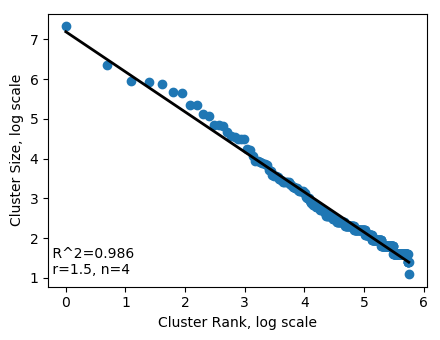

In [95]:
fig=figure(figsize=(4.5,3.5))
scatter(xdatalin, ydatalin, marker="o")
plot(xdatalin, fauxlin.(xdatalin), color="black", lw=2)
ylabel("Cluster Size, log scale")
xlabel("Cluster Rank, log scale")

annotate(" R^2=0.986 \n r=1.5, n=4",
            xy=(0, 0), xycoords="axes fraction",
            xytext=(0, 10), textcoords="offset pixels",
            horizontalalignment="left",
            verticalalignment="bottom")
tight_layout()
savefig("zipfexample.png",dpi=92)

# Markov Cluster

Aqui vamos a probar el Markov Clustering

In [101]:
f(x)= x !=0 ? x : 0 

f (generic function with 1 method)

In [103]:
pesos=f.(dd3d);

In [ ]:
mark=mcl(pesos, maxiter=10)

# Aqui abajo esta el Jerarquico.

In [ ]:
h4d=hclust(dd4d)
h3d=hclust(dd3d)
h2d=hclust(dd2d)

In [ ]:
hcorta=0.333 #estrictamente mas
clust4d=cutree(h4d,h=hcorta)
clust3d=cutree(h3d,h=hcorta)
clust2d=cutree(h2d,h=hcorta);

In [ ]:
size(unique(clust4d))

In [ ]:
scatterclust(frunciofiltrado, clust4d)
scatterclust(frunciofiltrado, clust3d)
scatterclust(frunciofiltrado,clust2d)

In [ ]:
temp=hcat(frunciofiltrado, db2d.assignments)
dict2d=declustaset(temp, enteros=false)
blabla2d=filtraclusterchicos(dict2d, 20);

In [ ]:
length(keys(blabla2d))

In [ ]:

for k in keys(blabla2d)
    l=length(blabla2d[k])
    println(" el grupo $k tiene $l elementos para regiones de Sources")
 end



In [ ]:
  punchis=[0 0 0 0]
for k in (0,)
    punchis=[0 0 0 0]
    for h in dict2d[k]
        punchis=vcat(punchis, h)
    end
end

In [ ]:

fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(punchis[:,1],punchis[:,2], s=0.5,c=punchis[:,4], cmap="inferno")
colorbar(fraction=0.045)

In [ ]:
blatabla3d=dictatabla(blabla2d);
#buf=dictatabla(blabla3d, una=false)

In [ ]:
fafa=figure(figsize=(5,4))

#ax=gca()
#ax.set_facecolor("k")
axis("equal")

xlim(-5.0,65.0)
ylim(0.0,65.0)
scatter(blatabla3d[:,1], blatabla3d[:,2], c=blatabla3d[:,5], s=0.5, cmap="inferno")
scatter((-1).*blatabla3d[:,1].+62, blatabla3d[:,2], c=blatabla3d[:,5], s=0.5, cmap="inferno")

show()
#colorbar()

In [ ]:
unique(blatabla[:,3])

In [ ]:
using QHull

In [ ]:
convexas=Dict{Any, Any}()
for k in keys(buf)
    puf =buf[k]
    print(k, " ")
    ch = chull(puf)
    convexas[k]=ch
end

In [ ]:
poly=PyPlot.matplotlib.patches.Polygon
appnplot=PyPlot.matplotlib.patches
colect=matplotlib.collections.PatchCollection

In [ ]:
keys(colect)

In [ ]:
orderhull=Dict{Any, Any}()
for k in keys(convexas)
    plaf=[0 0]
    for j in convexas[k].vertices
        aux=transpose(convexas[k].points[j,:])
        plaf=vcat(plaf, aux)
    end
    orderhull[k]=plaf[2:end,:]
end

In [ ]:
f=figure(figsize=(6,6))
fig, ax = plt.subplots()
popo=[]
for k in values(orderhull)
    punch=poly(k, true)
    push!(popo, punch)
end
cucu=colect(popo, alpha=0.5)
cucu.set_array(1:50)
ax.add_collection(cucu)
fig.colorbar(cucu, ax=ax)

#savefig("tuabuela.png", dpi=92)
show(f)